## Lesson 18:
### Exercise 1: Supernova distances and redshifts (part 2)

Let's continue working on the dataset from the previous exercise.

In [545]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

from astroML.datasets import generate_mu_z
from astropy.cosmology import LambdaCDM

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

%config InlineBackend.figure_format='retina'
#----------------------------------------------------------
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=False)
#----------------------------------------------------------
c = sns.color_palette('Paired', 7)
plt.rcParams['figure.figsize'] = (8, 5)

In [546]:
print('Seaborn color palette:')
c

Seaborn color palette:


[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883)]

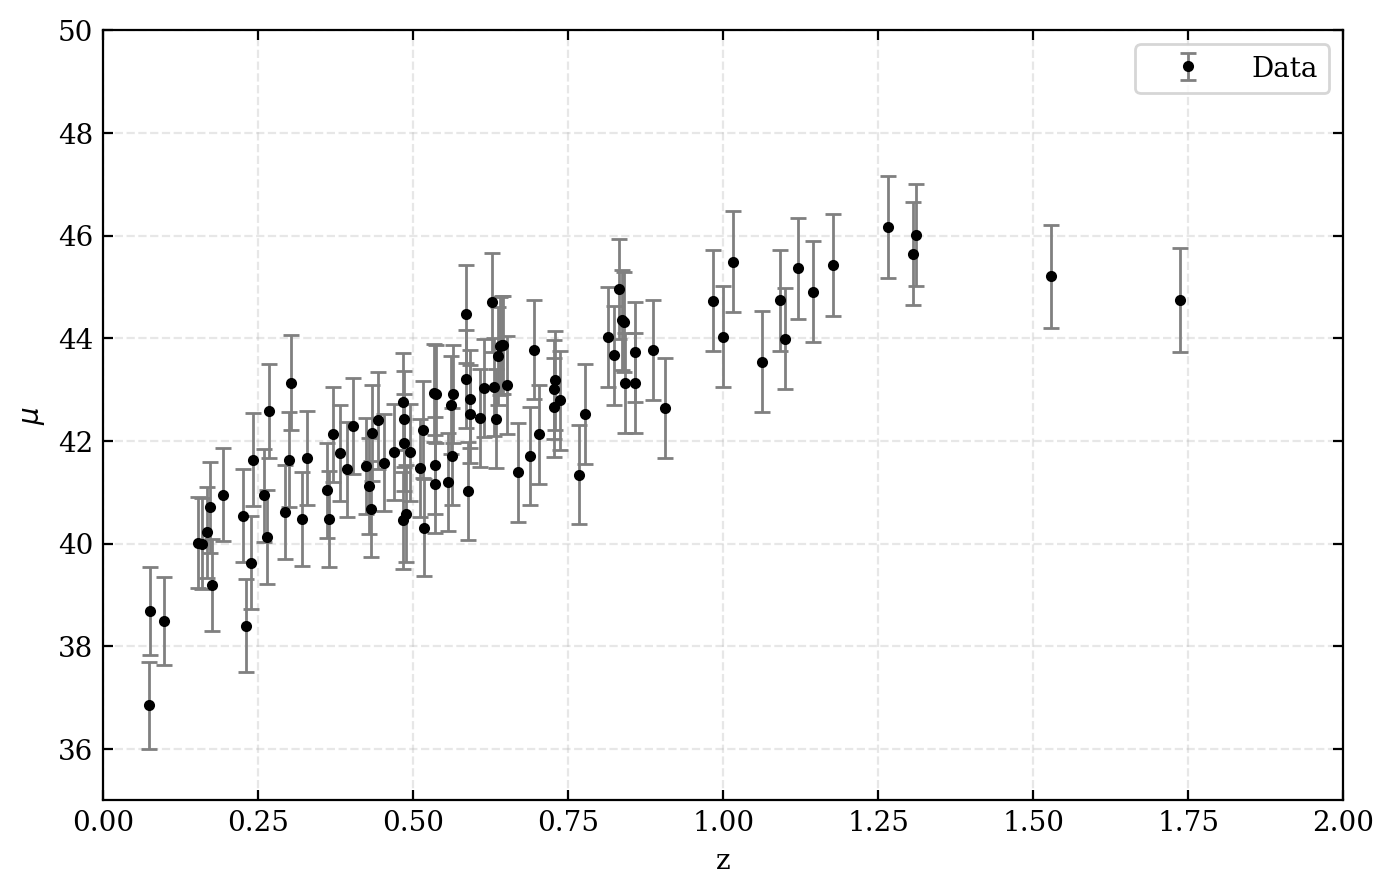

In [547]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='best')
plt.xlim(0,2)
plt.ylim(35,50)
plt.grid(True, ls='--', alpha=0.3)

### Gaussian Process Regression (GPR)

In doing a GP regression, the choice of the kernel can dramatically influence the final outcome. Here, among all the available kernels, we've chosen the *Radial Basis Function Kernel* or *Squared Exponential Kernel*, which has become a default kernel in Gaussian Process Regression. 

This particular kernel has the following form, with only two parameters:
$$k_{RBF}(x_1, x_2) = \sigma^2 \exp \Big({-\frac{(x_1 - x_2)^2}{2\mathcal{l^2}}}\Big)$$

What we need to fine tune in *sklearn.gaussian_process.kernels.RBF* module is the lengthscale $\mathcal{l}$. We need to specify also its lower/upper bounds. 

Quoting *David Duvenaud's* [Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/):
> **"The lengthscale $\mathcal{l}$ determines the length of the 'wiggles' in your function. The lengthscale will usually end up being determined by the smallest 'wiggle' in your function.**

We also need to provide the observational errors to the GaussianProcessRegressor object through the *alpha* parameter. These are added in quadrature to the diagonal terms of the covariance matrix of the input points.

/home/nicolofiaba/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1.2. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


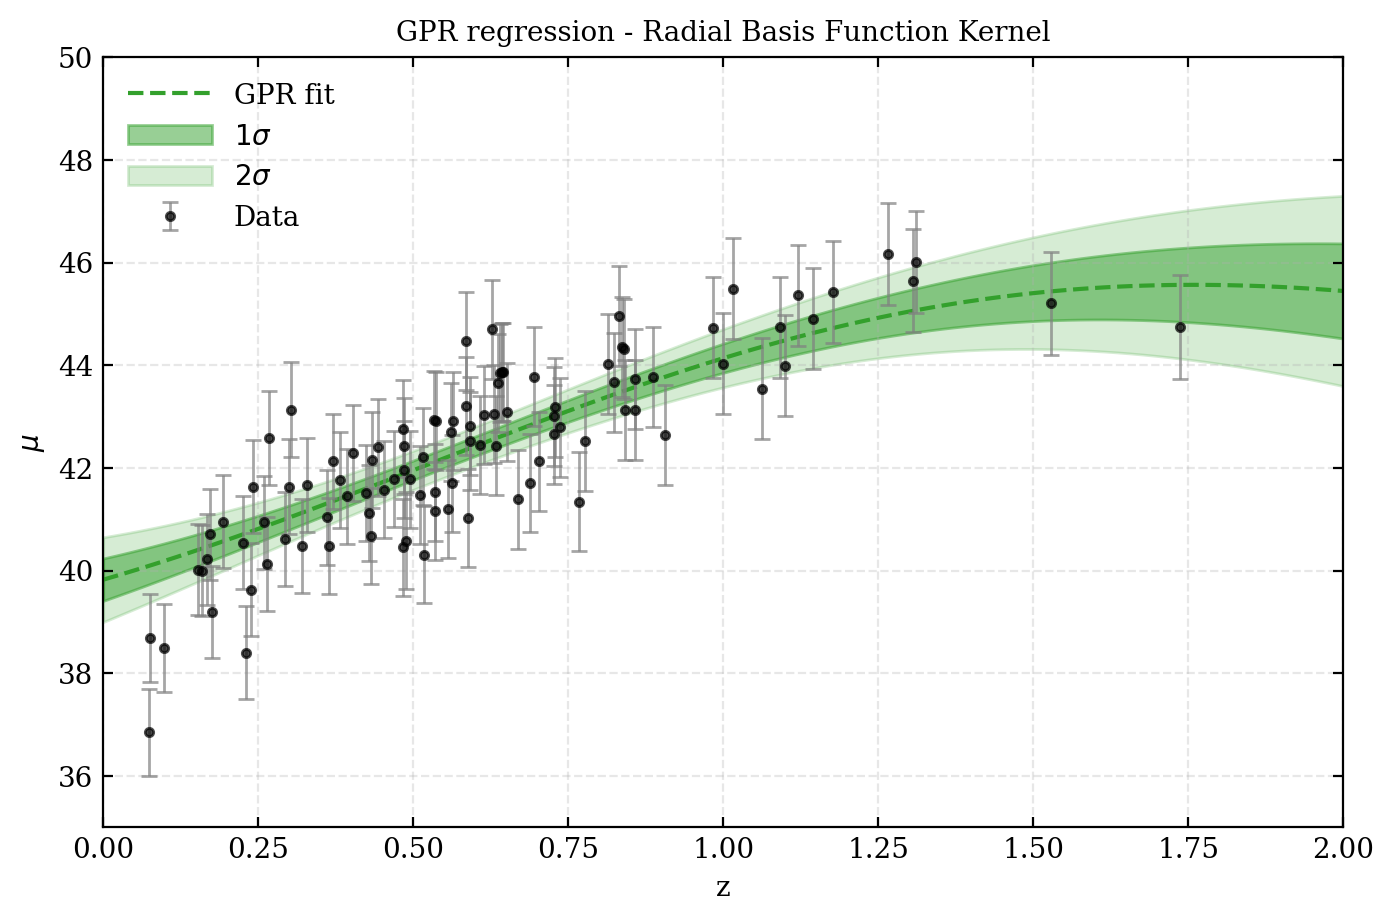

In [548]:
ls = 1.2
kernel = kernels.RBF(ls, (ls,ls))

gp = GaussianProcessRegressor(kernel = kernel, alpha= dmu, normalize_y=True)

gp.fit(z_sample[:, None], mu_sample)

xgrid = np.linspace(0, 2, 100)
y_pred, dy_pred = gp.predict(xgrid[:, None], return_std=True)

plt.plot(xgrid, y_pred, label='GPR fit', color=c[3], ls='--')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data', alpha=0.7)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title(f'GPR regression - Radial Basis Function Kernel')

plt.fill_between(xgrid, y_pred - dy_pred, y_pred + dy_pred, 
                color = c[3], alpha=0.5, label=f'$1\sigma$')

plt.fill_between(xgrid, y_pred - 2*dy_pred, y_pred + 2*dy_pred, 
                color = c[3], alpha=0.2, label=f'$2\sigma$')

plt.grid(True, ls='--', alpha=0.3)
plt.legend(loc='upper left', frameon=False);

Now, from $\Lambda$CDM Cosmology theory, the relationship between the redshift $z$ and the distance module $\mu$ happens to be the following:

$$\mu = 5 \log_{10} \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$

with $H_0$ being the *Hubble constant* and $\Omega_m$ the matter content of the universe, assuming a flat universe.

Let's fit this model to our data.

In [549]:
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo

H0_known = cosmo.H(0).value #H0 in km/s/Mpc
c_light = const.c.to(u.km/u.s).value

In [550]:
def integrand(x, omega_m, omega_L):
    return (omega_m*(1+x**3)+omega_L)**(-1/2)

def mu_z_model(z, H0, omega_m):
    omega_L = 1 - omega_m
    coeff = (c_light/(H0*1e-5)) * (1+z) #the factor 10^-5 accounts for the units of H0
    integral, error = scipy.integrate.quad(integrand, 0, z, args=(omega_m, omega_L))
    return 5*np.log10(coeff*integral)

Try the model with $30\%$ of ordinary matter, $70\%$ of dark matter and $H_0 = H_0^{known}$.

In [551]:
ndim = 2
om_m = 0.5
mu = np.array([mu_z_model(x, H0_known, om_m) for x in xgrid[1:]])

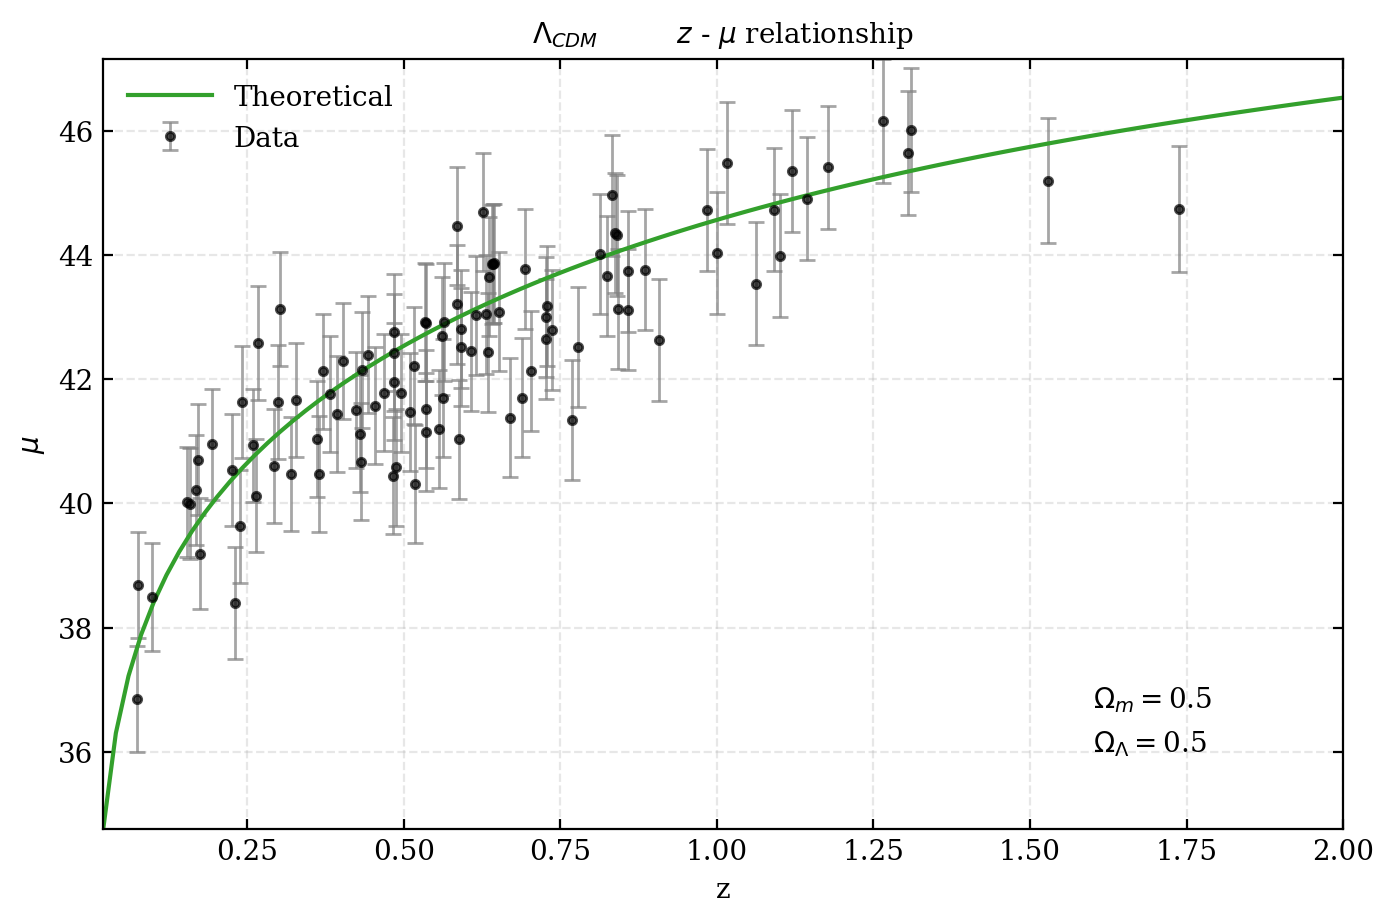

In [552]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data', alpha=0.7)
plt.plot(xgrid[1:], mu, color=c[3], label='Theoretical')
plt.grid(True, ls='--', alpha=0.3)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title(r'$\Lambda_{CDM}$         $z$ - $\mu$ relationship')
plt.text(1.60, 36.7, r'$\Omega_m = ${}'.format(om_m))
plt.text(1.60, 36, r'$\Omega_\Lambda = ${}'.format(round(1-om_m, 1)))
plt.legend(loc='upper left', frameon=False);

The two independent parameters of our model are $\Omega_m$ and $H_0$ since $\Omega_\Lambda = 1 - \Omega_m$ for a **flat universe**. 

We want to do the following:
- Get a Bayesian estimate of those parameters running an *MCMC* or a *Nested Sampling*
- Perform a model selection to discriminate between a model **with** Dark Matter ($\Omega_m \neq 0$) of **without** Dark Matter ($\Omega_m = 0$).

Since we will have to do a model selection, we will need to estimate the Bayesian Evidence, thus we'll choose a *Nested Sampling* approach.

### Nested sampling

First we define the $\log{L}$ and the prior transformation function. Notice that in this case we have heteroscedastic errors.

$$\ln{L} = \sum_{i=1}^{N} \ln \Big[ \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp \Big( \frac{(y_i - M(t_i,\theta))^2)}{2\sigma_i^2}\Big) \Big] = \sum_{i=1}^{N}  \Big[ \ln \Big(\frac{1}{\sqrt{2\pi\sigma_i^2}}\Big) - \Big( \frac{(y_i - M(t_i,\theta))^2)}{2\sigma_i^2}\Big) \Big]$$

In [553]:
import dynesty
from dynesty import plotting as dyplot

In [554]:
#Prior ranges for 2 parameters:
a1, b1 = 0, 100 #H0
a2, b2 = 0, 1 #omega_m

def transform_prior(u):
    if ndim == 2:
        ranges = [(a, b) for a, b in zip([a1, a2], [b1, b2])]
        params = [a + (b - a) * ui for (a, b), ui in zip(ranges, u)]
        return params
    if ndim == 1:
        return a1 + (b1 - a1) * u
        
def LogLikelihood(par):
    if ndim == 2:
        H0, omega_m = par
    elif ndim == 1:
        H0 = par
        omega_m = 1
    model = np.array([mu_z_model(z, float(H0), omega_m) for z in z_sample])
    f = (1/(2*dmu**2)) * ((mu_sample - model)**2) 
    k = -1/2 * np.log(2*np.pi*dmu**2)
    return np.sum(k - f)

In [555]:
ndim = 2 # ndim = 2: 2 parameter estimation
         # ndim = 1: 1 parameter estimation (omega_m = 1)
    
sampler = dynesty.NestedSampler(LogLikelihood, transform_prior, ndim)
sampler.run_nested()

1744it [00:17, 100.66it/s, +500 | bound: 0 | nc: 1 | ncall: 16167 | eff(%): 14.323 | loglstar:   -inf < -133.808 <    inf | logz: -136.413 +/-  0.048 | dlogz:  0.001 >  0.509]


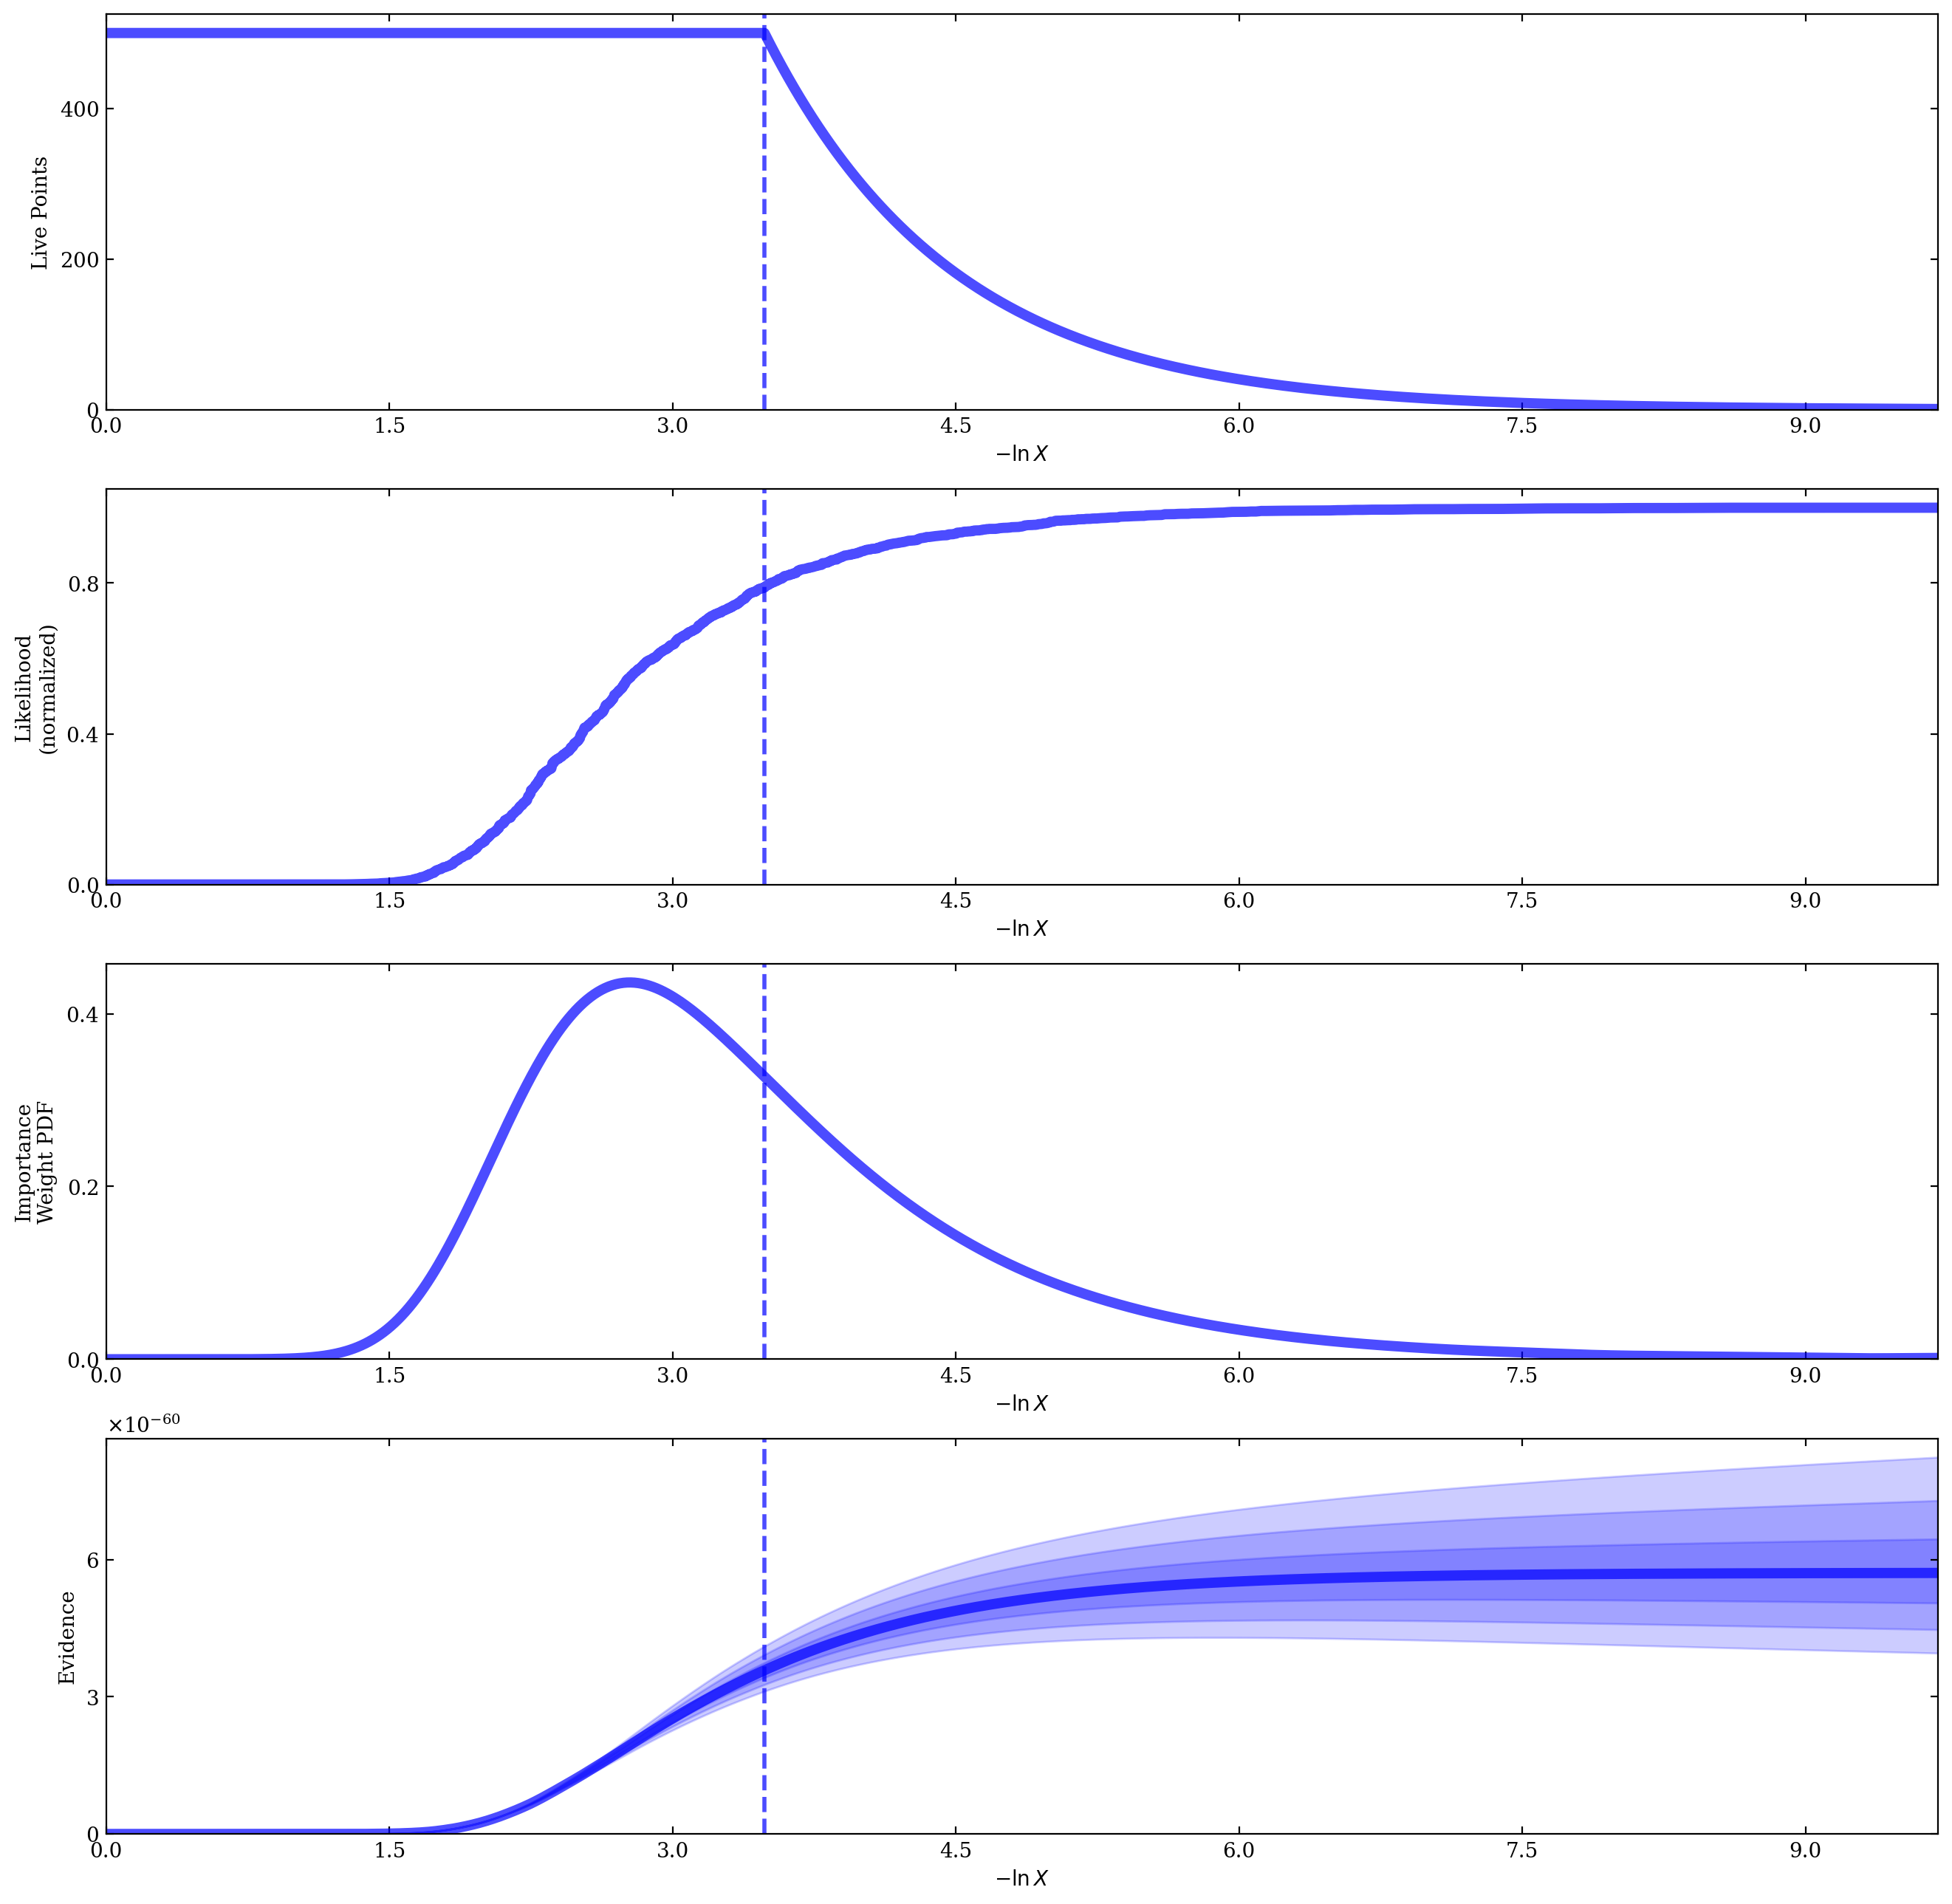

In [556]:
sresults = sampler.results
rfig, raxes = dyplot.runplot(sresults)

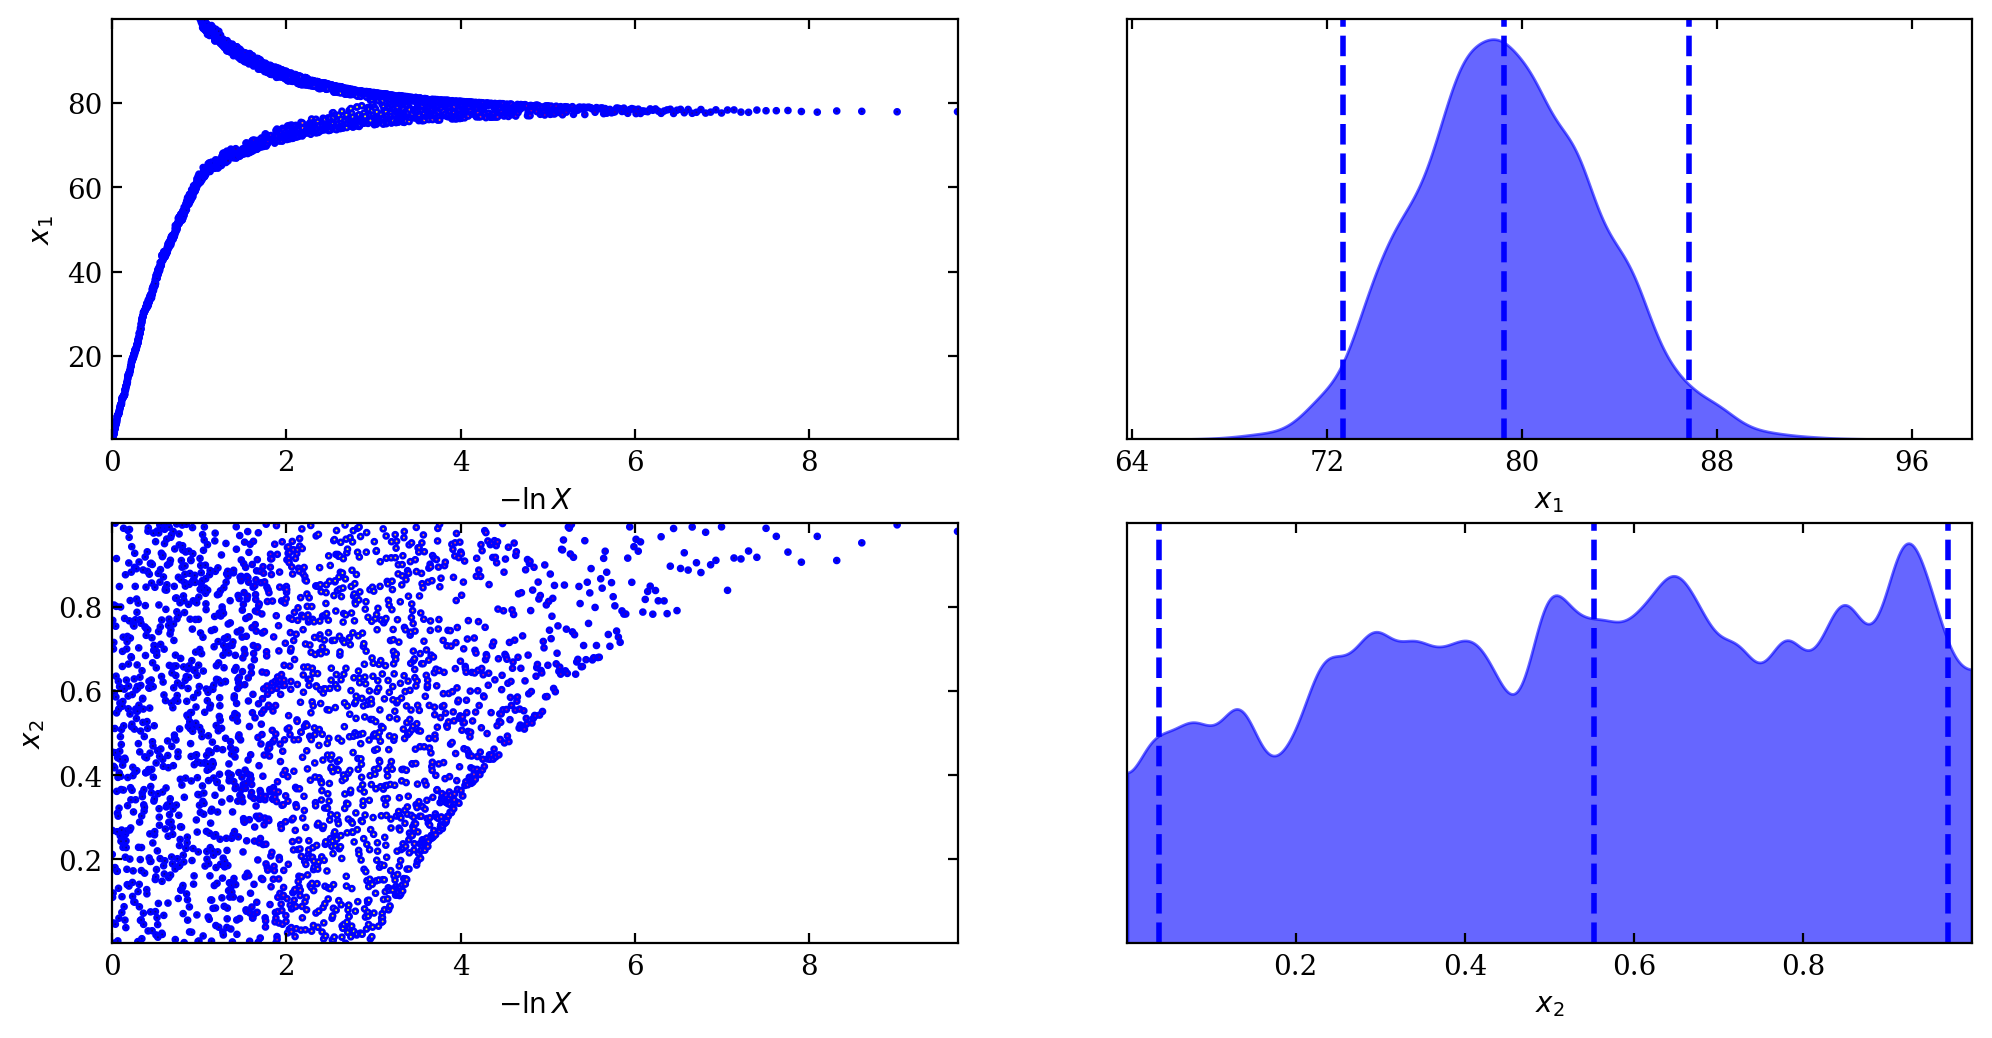

In [557]:
tfig, taxes = dyplot.traceplot(sresults)

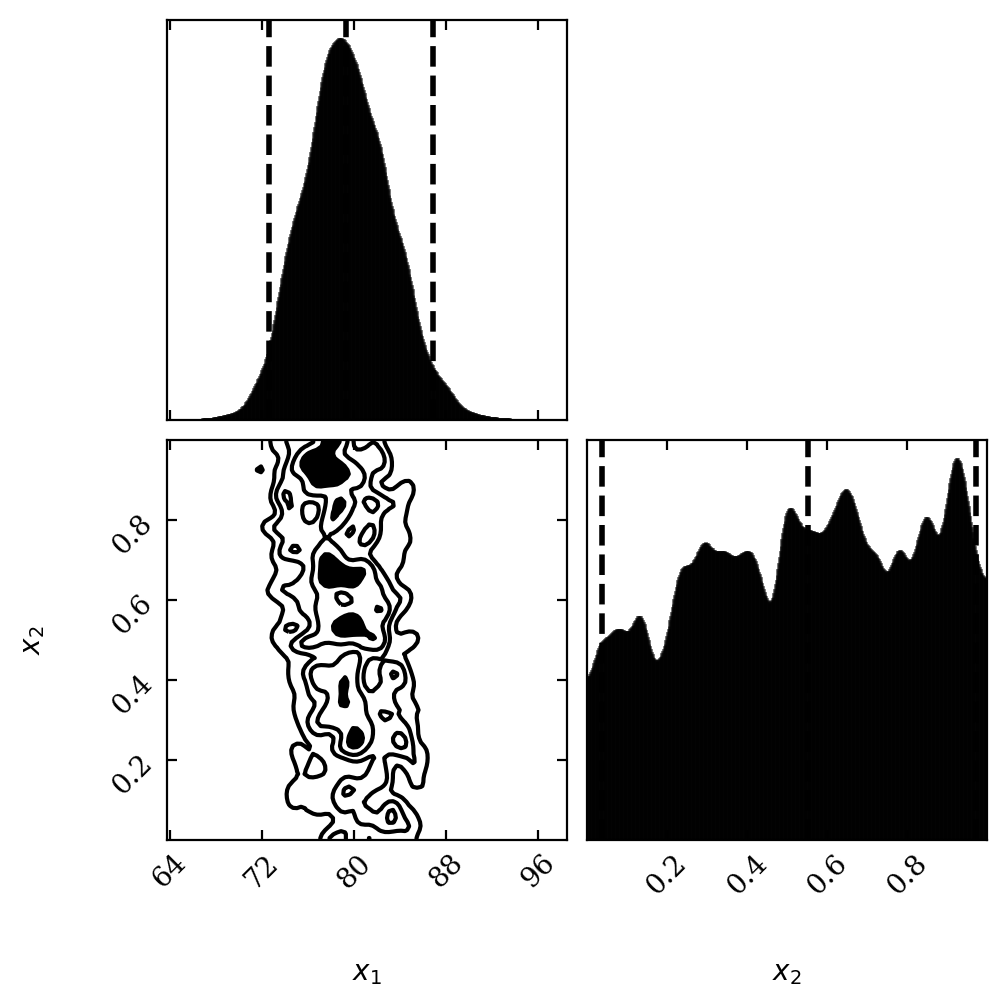

In [558]:
cfig, caxes = dyplot.cornerplot(sresults)

In [580]:
from dynesty import utils as dyfunc

samples = sresults.samples 
weights = np.exp(sresults.logwt - sresults.logz[-1]) 

evidence = np.exp(sresults.logz[-1]) #evidence
print("Bayesian evidence", evidence)

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('\nEstimated mean values are: \n H0: ' + str(mean[0]) + ' km/s/Mpc \n omega_m: ' + str(mean[1]))
print('\nCovariance matrix: \n ' + str(cov))

samples_equal = dyfunc.resample_equal(samples, weights)

Bayesian evidence 5.707232853107177e-60

Estimated mean values are: 
 H0: 79.39736857480251 km/s/Mpc 
 omega_m: 0.5380725914727276

Covariance matrix: 
 [[13.55315768 -0.26342492]
 [-0.26342492  0.07721517]]


In [560]:
ndim = 1

sampler_2 = dynesty.NestedSampler(LogLikelihood, transform_prior, ndim)
sampler_2.run_nested()

1664it [00:12, 130.13it/s, +500 | bound: 0 | nc: 1 | ncall: 15297 | eff(%): 14.625 | loglstar:   -inf < -133.808 <    inf | logz: -136.229 +/-  0.041 | dlogz:  0.001 >  0.509]


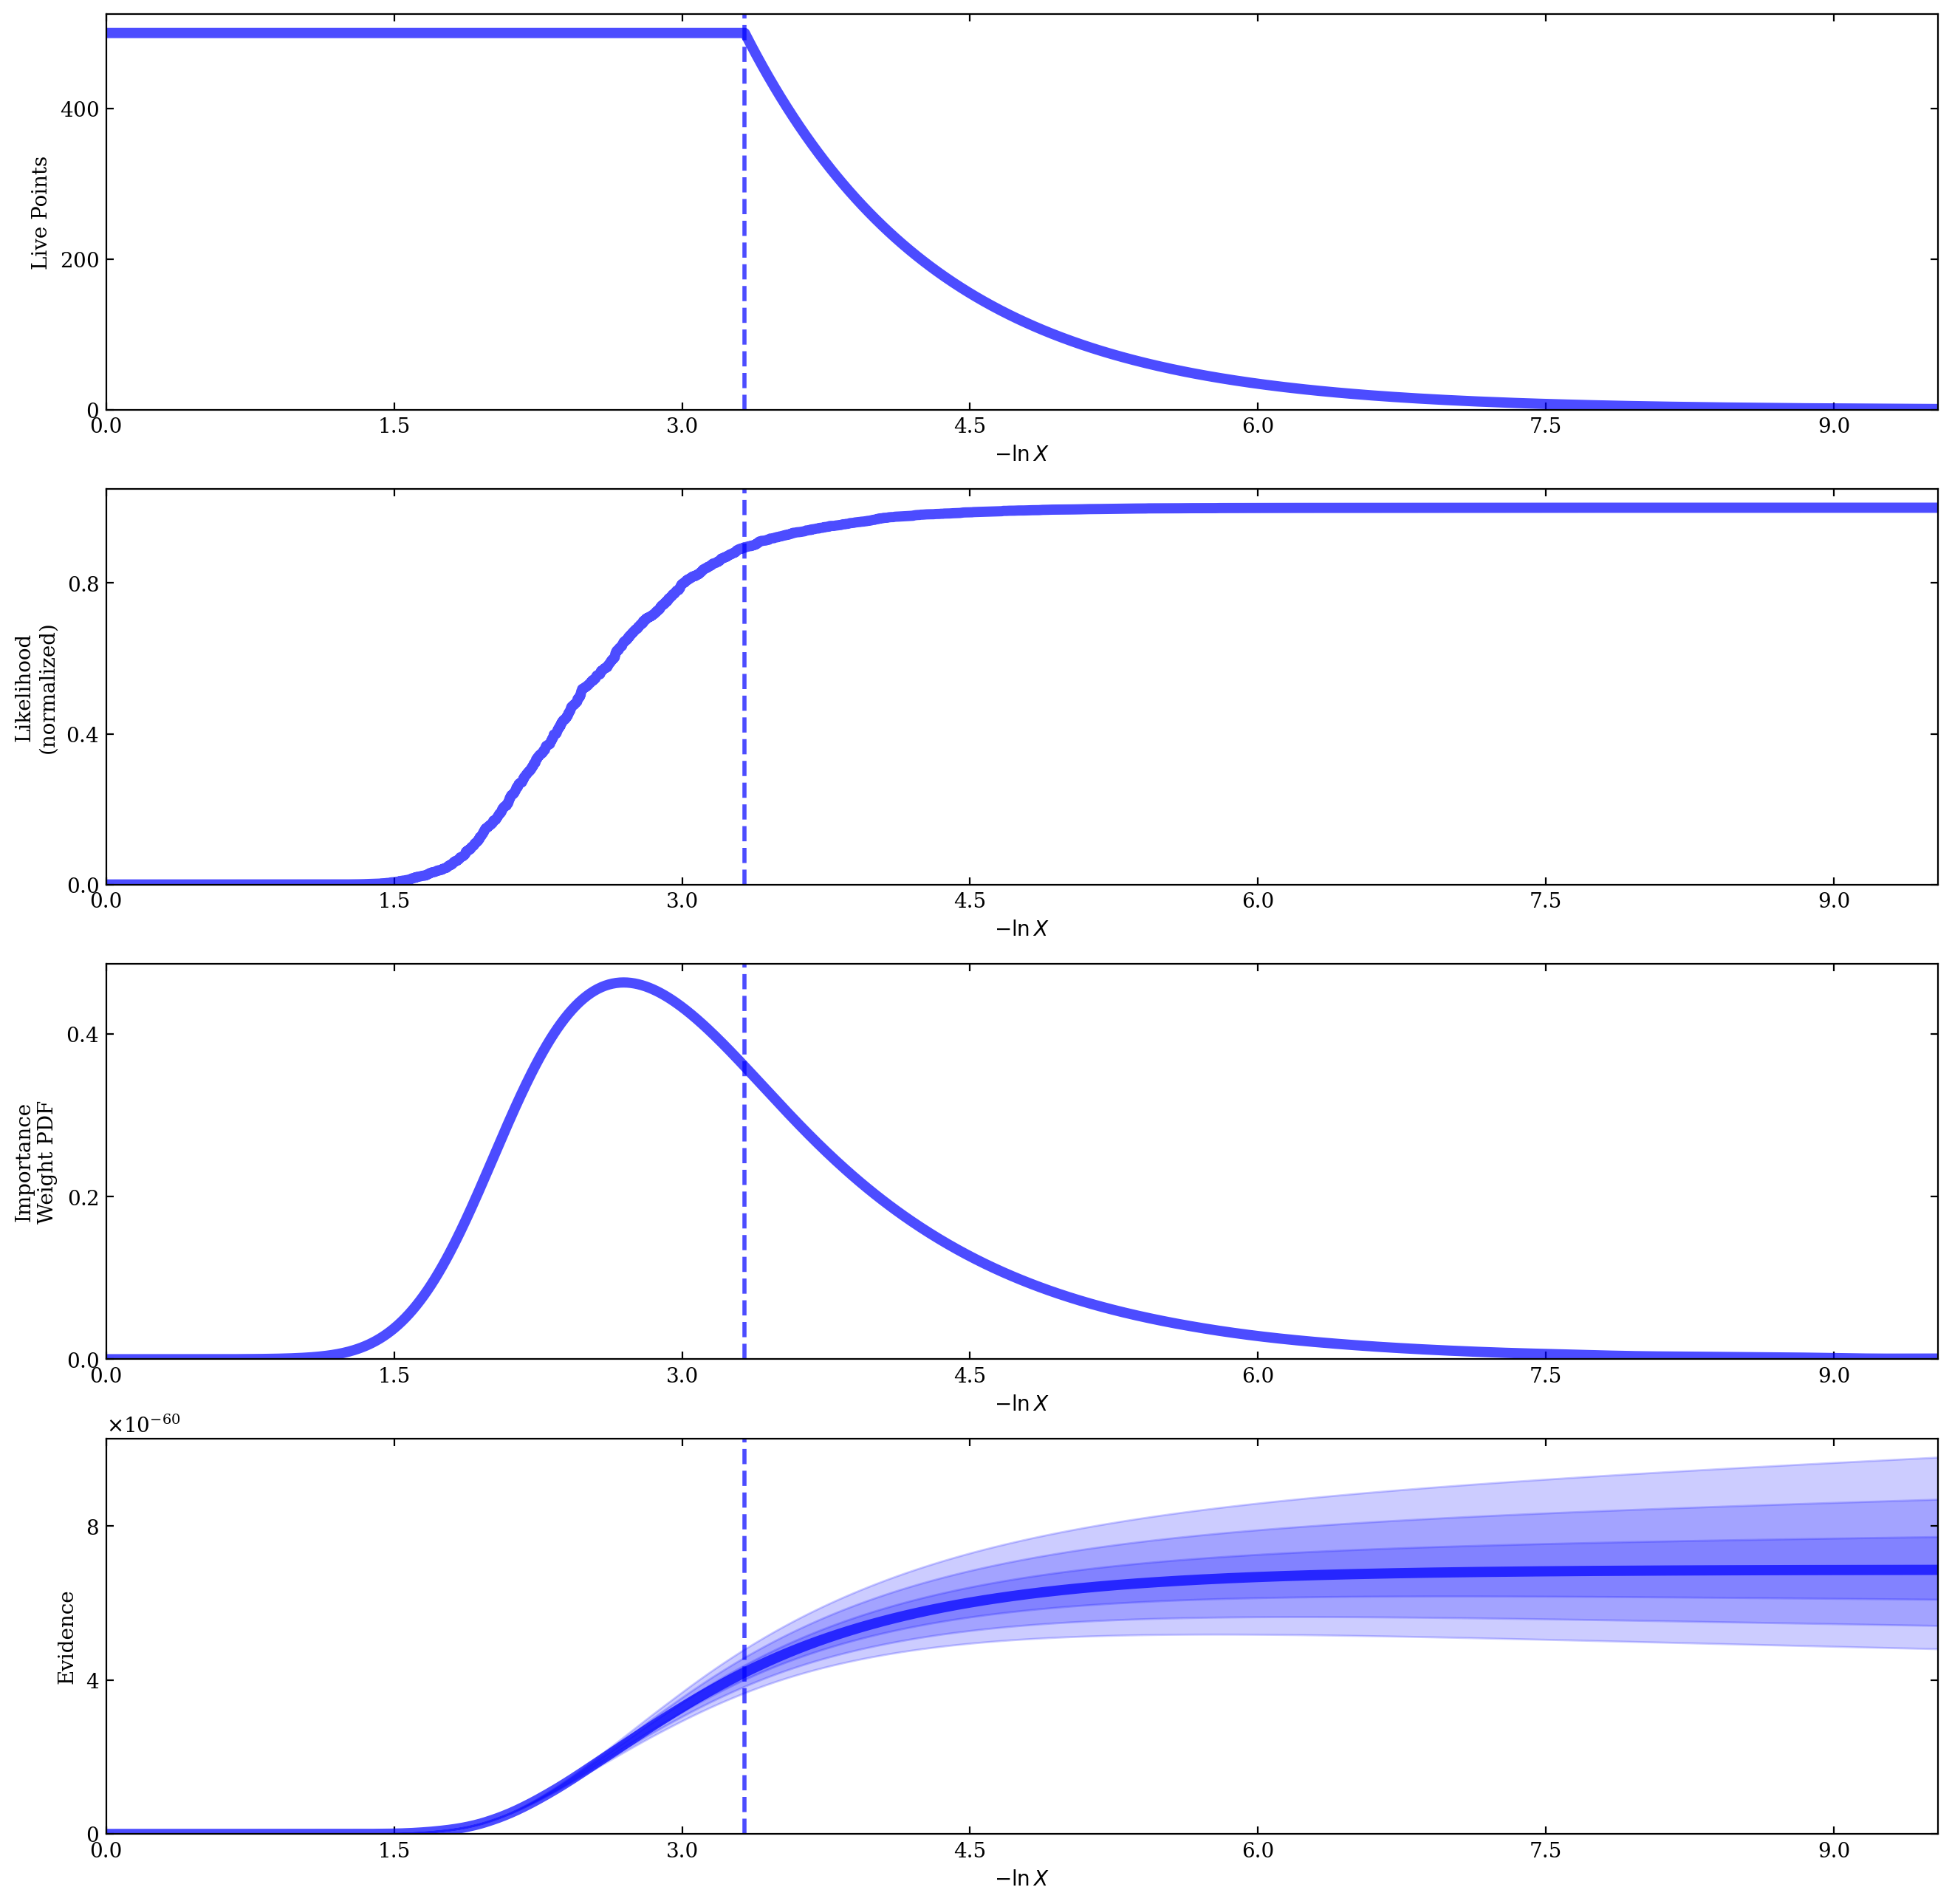

In [561]:
sresults_2 = sampler_2.results
rfig, raxes = dyplot.runplot(sresults_2)

In [573]:
samples_2 = sresults_2.samples 
weights_2 = np.exp(sresults_2.logwt - sresults_2.logz[-1]) 

evidence_2 = np.exp(sresults_2.logz[-1])
print("Bayesian evidence", evidence_2)

# Compute weighted mean and covariance.
mean_2, cov_2 = dyfunc.mean_and_cov(samples_2, weights_2)
print('\nEstimated mean values are: \n H0: ' + str(mean_2[0]) + ' km/s/Mpc')
print('\nCovariance matrix: \n ' + str(cov_2))

samples_2_equal = dyfunc.resample_equal(samples_2, weights_2)

Bayesian evidence 6.863902275246664e-60

Estimated mean values are: 
 H0: 78.15314016443843 km/s/Mpc

Covariance matrix: 
 [[11.18704314]]


#### Bayes factor

In [563]:
B_12 = evidence/evidence_2
np.log(B_12)

-0.18454183275741795

According to Jeffrey scale for the interpretation of Bayes Factors, the model selection is **inconclusive.**
We would need more data to discriminate between a **DM** universe and a **no-DM** one.

### Upsampling the data
- with GPR fit: The *predict* method of the GaussianProcessRegressor gives us the predicted value at each $z$ as well as its $\sigma$. We can draw a random sample for each z from a Gaussian distribution centered around the predicted value, with a width given by $\sigma$.
- with $\Lambda$**CDM** fit: Nested Sampling gives us samples of the parameter space. We can draw a random sample of the two model parameters for each $z$, then predict the $\mu$ value from the model itself. The distribution we obtain will reflect the uncertainty on the parameters.

In [773]:
zgrid = np.linspace(0,2,1000) # We want 10 times more measurements

In [774]:
gpr, sig = gp.predict(zgrid[:, None], return_std=True)

/tmp/ipykernel_23598/4294060938.py:8: RuntimeWarning: divide by zero encountered in log10
  return 5*np.log10(coeff*integral)


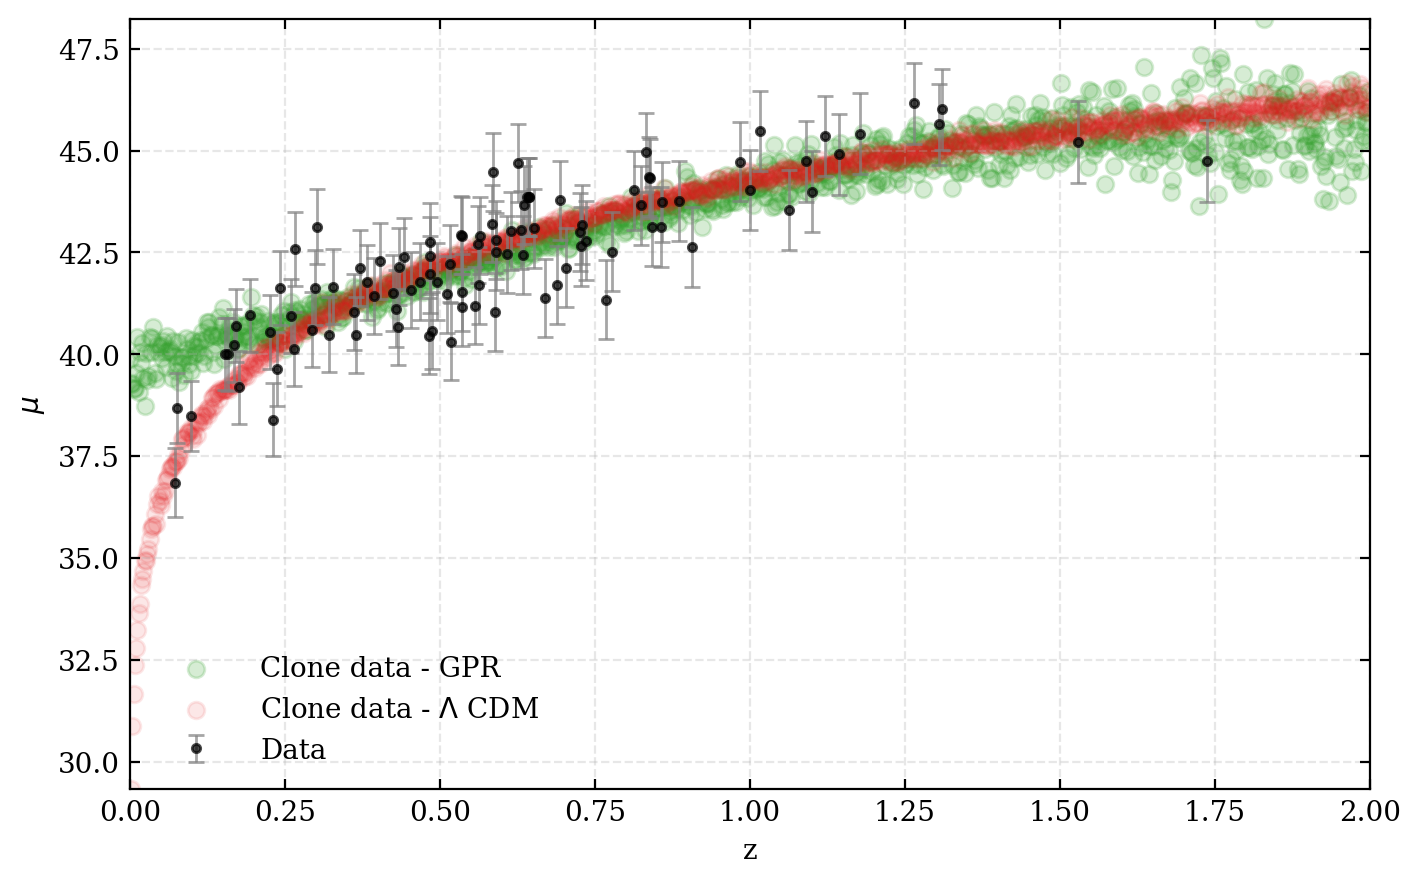

In [778]:
mu_gpr = []
mu_cdm = []

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data', alpha=0.7)
mu_gpr.append(np.random.normal(loc=gpr, scale=sig))

for z in zgrid:
    rand_ind = np.random.choice(len(samples_equal))
    random_par = samples_equal[rand_ind]
    mu_cdm.append(mu_z_model(z, random_par[0], random_par[1]))
    
plt.scatter(zgrid, mu_gpr, color=c[3], alpha=0.2, label='Clone data - GPR')
plt.scatter(zgrid, mu_cdm, color=c[5], alpha=0.1, label='Clone data - $\Lambda$ CDM')

plt.legend(loc='best', frameon=False);
plt.grid(True, ls='--', alpha=0.3)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.show()